<a href="https://colab.research.google.com/github/matdcp/Data-dreamers-/blob/main/DEA_da_consegnare_ufficiale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

# Carica i file manualmente
uploaded = files.upload()  # Seleziona i file file1.ann e file2.ann dalla tua scrivania

Saving file2.ann to file2.ann
Saving file1.ann to file1.ann


Loading required libraries

In [ ]:
import csv
import pandas as pd
!pip install pandas matplotlib wordcloud pyLDAvis
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
import spacy
import numpy as np
import seaborn as sns
from scipy.interpolate import make_interp_spline
from collections import Counter
import numpy as np
import re
from wordcloud import WordCloud
import gensim
from gensim import corpora
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import math
import warnings
import ploty.express as px

warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.1 MB/s eta 0:00:00


Loading the dataset

In [ ]:
# Funzione per convertire un file .ann in .csv
def convert_ann_to_csv(input_file, output_file):
    data = []
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()  # Rimuovi spazi vuoti
            if line and '\t' in line:  # Controlla che non sia vuota e contenga tabulazioni
                parts = line.split('\t')
                if len(parts) == 4:  # Controlla che ci siano esattamente 4 colonne
                    id, start, end, label = parts
                    # Filtra token non alfanumerici o righe non valide
                    if id.isalnum() or len(id) >= 1:  # Mantieni token validi
                        try:
                            # Prova a convertire start e end in interi
                            data.append([id, int(start), int(end), label])
                        except ValueError:
                            continue

    # Scrivi il file CSV
    with open(output_file, 'w', encoding='utf-8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['id', 'Start', 'End', 'Label'])  # Intestazioni
        writer.writerows(data)

# Percorsi dei file .ann
file1_ann_path = 'file1.ann'  # Sostituisci con il percorso reale
file2_ann_path = 'file2.ann'  # Sostituisci con il percorso reale

# Percorsi dei file CSV temporanei
file1_csv_path = 'file1_converted.csv'
file2_csv_path = 'file2_converted.csv'

# Conversione dei file .ann in .csv
convert_ann_to_csv(file1_ann_path, file1_csv_path)
convert_ann_to_csv(file2_ann_path, file2_csv_path)

# Caricamento dei file CSV convertiti in DataFrame
df1 = pd.read_csv(file1_csv_path)
df2 = pd.read_csv(file2_csv_path)

# Unione dei DataFrame
ds = pd.concat([df1, df2], ignore_index=True)

# Salvataggio del dataset unito come CSV
merged_dataset_path = 'merged_dataset.csv'
ds.to_csv(merged_dataset_path, index=False)

# Visualizzazione del risultato
print(f"Dataset unito salvato come '{merged_dataset_path}'")
print(ds.head(13))



Dataset unito salvato come 'merged_dataset.csv'
              id  Start  End                     Label
0    Ventricular      0   11  B-Multi-tissue_structure
1   fibrillation     12   24                         O
2            due     25   28                         O
3             to     29   31                         O
4           long     32   36                         O
5             QT     37   39                         O
6       syndrome     40   48                         O
7       probably     49   57                         O
8         caused     58   64                         O
9             by     65   67                         O
10   clindamycin     68   79                         O
11             .     79   80                         O
12  Prolongation     81   93                         O


# **1. DATA EXPLORATORY ANALYSIS (DEA)**

# MISSING VALUES

Handling missing values is a critical step in any data preprocessing pipeline, as they can introduce bias or reduce the performance of subsequent analyses and models.

In [ ]:
ds.isnull().sum()

,0
id,18
Start,0
End,0
Label,0


The dataset contains 18 missing values, which could negatively impact subsequent analyses and operations. To address this issue, we will simply remove these missing entries using the pandas dropna() function. This approach ensures a cleaner and more reliable dataset for further processing.

In [ ]:
ds.dropna(inplace=True)

# Classification labels frequency



As the first step of the exploratory analysis, we printed all the named entity recognition (NER) tags along with their frequencies in the biomedical papers under analysis.

In [ ]:
ds['Label'].unique()

array(['B-Multi-tissue_structure', 'O', 'B-Organism_substance',
       'B-Organism_subdivision', 'B-Organ', 'I-Multi-tissue_structure',
       'B-Cellular_component', 'I-Cellular_component', 'B-Cell', 'I-Cell',
       'B-Immaterial_anatomical_entity', 'B-Tissue', 'I-Tissue',
       'B-Pathological_formation', 'B-Anatomical_system',
       'I-Organism_substance', 'I-Anatomical_system',
       'I-Pathological_formation', 'I-Immaterial_anatomical_entity',
       'I-Organ', 'I-Organism_subdivision',
       'B-Developing_anatomical_structure',
       'I-Developing_anatomical_structure'], dtype=object)

In [ ]:
ds['Label'].value_counts()

,count
Label,
O,112934
B-Cell,776
B-Multi-tissue_structure,639
I-Cell,543
B-Organ,381
I-Multi-tissue_structure,372
B-Pathological_formation,368
B-Organism_substance,291
I-Pathological_formation,248


In [ ]:
count_O = ds['Label'].value_counts().get('O',0)
print(count_O)
O_frequency = (count_O / len(ds)) *100
print(O_frequency)

112934
96.01761635123876


In the following, we performed a mapping of the NER tags by grouping the labels of the same class, marked with either I or B, into a single representative label for each class. This was done to provide a clearer representation of the frequency with which each class appears in the text.
Hence, We represented the token distribution per class using histograms, both before and after applying the mapping.

For the purpose of creating an explanatory graphical representation of the frequency, I excluded the Outside (O) NER tags from the mapping. This decision was made because, as observed in the output of the counts, there is a clear and significant imbalance, with O representing 96% of the total NER tags.

In [ ]:
# mapping lables

mapping = {'B-Multi-tissue_structure': 'Multi-tissue_structure',
           'I-Multi-tissue_structure': 'Multi-tissue_structure',
           'B-Organism_substance':'Organism_substance',
           'I-Organism_substance':'Organism_substance',
           'B-Organism_subdivision':'Organism_subdivision',
           'I-Organism_subdivision':'Organism_subdivision',
           'B-Organ':'Organ',
           'I-Organ':'Organ',
           'B-Cellular_component':'Cellular_component',
           'I-Cellular_component':'Cellular_component',
           'B-Cell':'Cell',
           'I-Cell':'Cell',
           'B-Immaterial_anatomical_entity':'Immaterial_anatomical_entity',
           'I-Immaterial_anatomical_entity':'Immaterial_anatomical_entity',
           'B-Tissue':'Tissue',
           'I-Tissue':'Tissue',
           'B-Pathological_formation':'Pathological_formation',
           'I-Pathological_formation':'Pathological_formation',
           'B-Anatomical_system':'Anatomical_system',
           'I-Anatomical_system':'Anatomical_system',
           'B-Developing_anatomical_structure':'Developing_anatomical_structure',
           'I-Developing_anatomical_structure':'Developing_anatomical_structure',
           'O': 'O'

}

In [ ]:
mapped_ds = ds.copy()
ds1 = ds.copy()
mapped_ds['Label'] = mapped_ds['Label'].map(mapping)
mapped_ds_without_O= mapped_ds[mapped_ds['Label'] != 'O']
ds_without_O = ds1[ds1['Label'] != 'O']

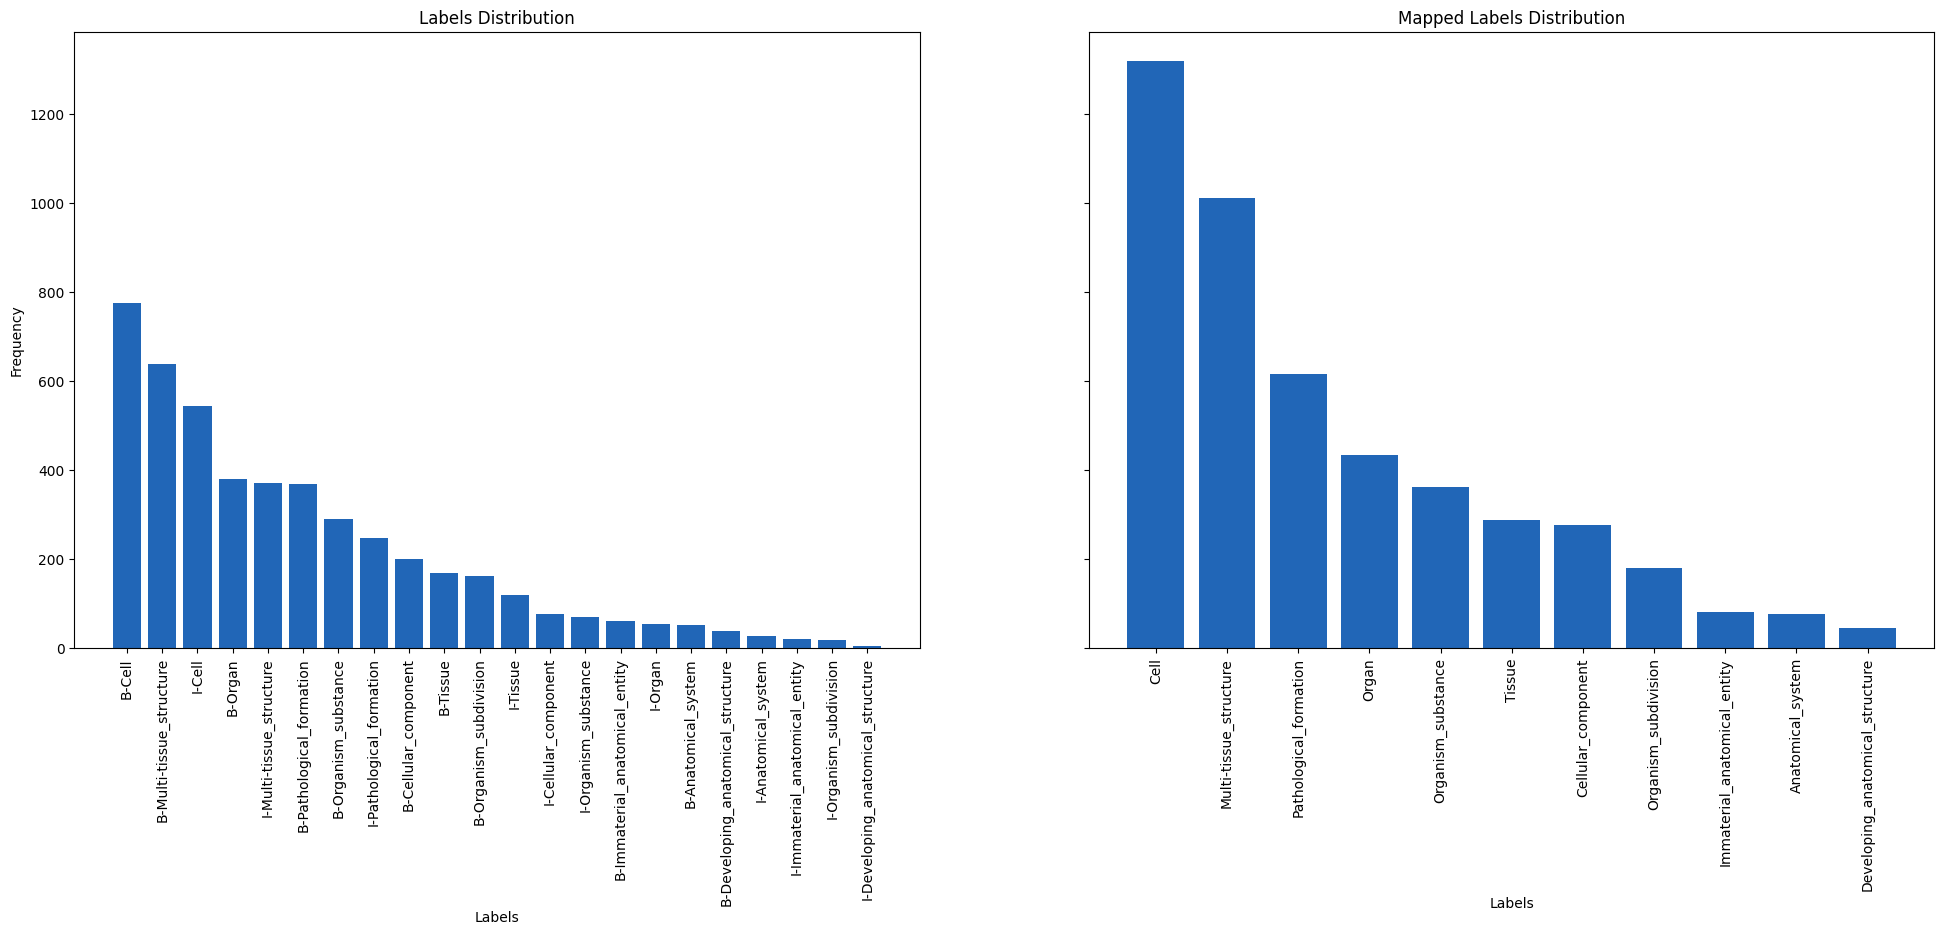

In [ ]:
import matplotlib.pyplot as plt

label_counts_mapped = mapped_ds_without_O['Label'].value_counts()
label_counts = ds_without_O['Label'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(24, 8), sharey=True)  # sharey per condividere la scala Y

axes[0].bar(label_counts.index, label_counts.values, color='#2166b7')
axes[0].set_title('Labels Distribution')
axes[0].set_xlabel('Labels')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=90)

axes[1].bar(label_counts_mapped.index, label_counts_mapped.values, color='#2166b7')
axes[1].set_title('Mapped Labels Distribution')
axes[1].set_xlabel('Labels')
axes[1].tick_params(axis='x', rotation=90)

plt.show()



Based on the histograms, before the mapping, the dataset exhibits a higher granularity with distinct "B-" and "I-" prefix labels representing token positions in entities. After the mapping, the labels are consolidated into broader categories, reducing the overall complexity and improving the class balance. This transformation helps simplify the classification task while retaining the essential distinctions needed for entity extraction.

So now we want to show the distribution of the length of the sentences in our dataset.

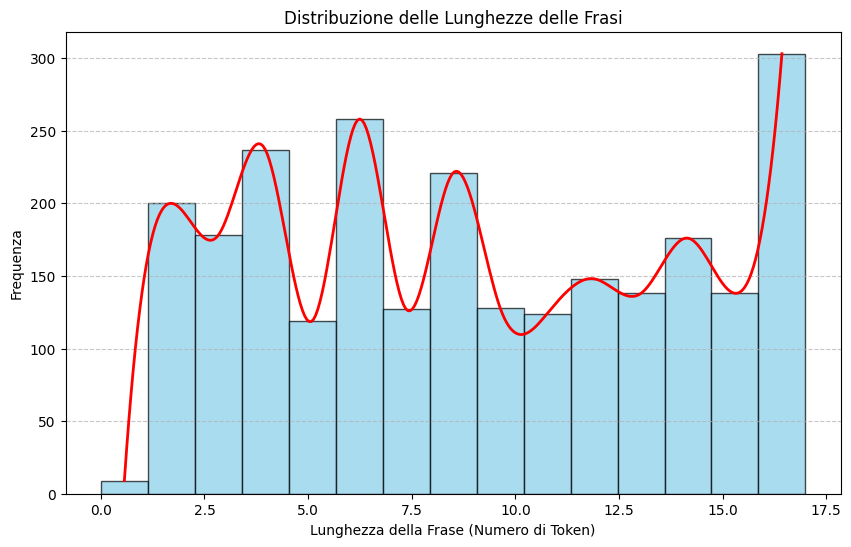

In [ ]:
# Identify sentence boundaries using punctuation (e.g., ".", "!", "?")
sentence_ending_tokens = [".", "!", "?"]

# Create a new 'Sentence_ID' column
ds['Sentence_ID'] = (ds['id'].isin(sentence_ending_tokens)).cumsum()

# Count the number of tokens per sentence
sentence_lengths = ds.groupby('Sentence_ID').size()

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=15, range=(0, 17), color='skyblue', edgecolor='black', alpha=0.7)

# Curve smoothing
bin_counts, bin_edges = np.histogram(sentence_lengths, bins=15, range=(0, 17))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
xnew = np.linspace(bin_centers.min(), bin_centers.max(), 300)
spline = make_interp_spline(bin_centers, bin_counts, k=3)
y_smooth = spline(xnew)

# Add the smoothed curve
plt.plot(xnew, y_smooth, color='red', linewidth=2)

# Customize the plot
plt.title("Distribuzione delle Lunghezze delle Frasi")
plt.xlabel("Lunghezza della Frase (Numero di Token)")
plt.ylabel("Frequenza")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



As we can see from the graph the sentences in our dataset have different lengths, there are sentences of less than 5 words and as well long sentences of more than 15 words

POS (Part-of-Speach) analysis: in the next codes we're going analyze and visulize the distribution of the POS in our data in oreder to understand the linguistic structure of the sentences.

In [ ]:
# Carica il modello spaCy
nlp = spacy.load('en_core_web_sm')

# Esegui il POS tagging sul dataset
def pos_tagging(text):
    doc = nlp(text)
    return [token.pos_ for token in doc]


# Unisci i token per creare frasi
if 'Sentence_ID' in ds.columns:
    ds['sentence'] = ds.groupby('Sentence_ID')['id'].transform(lambda x: ' '.join(x))

# Rimuovi duplicati e tieni solo le frasi uniche
unique_sentences = ds[['sentence']].drop_duplicates().dropna()

# Applica il POS tagging a ciascuna frase
unique_sentences['POS'] = unique_sentences['sentence'].apply(pos_tagging)

# Conteggia le occorrenze delle POS
pos_counts = Counter([pos for pos_list in unique_sentences['POS'] for pos in pos_list])

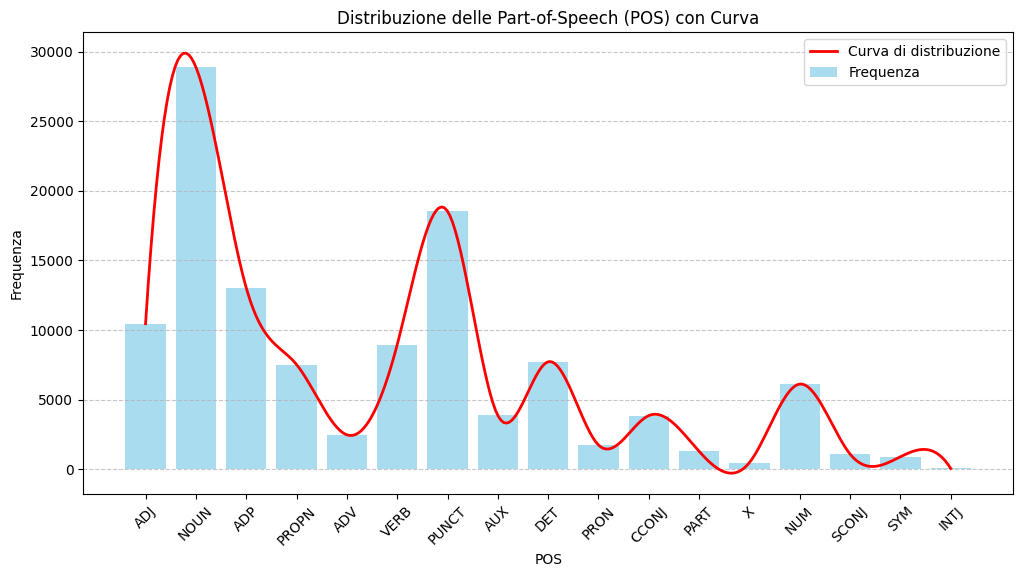

In [ ]:
plt.figure(figsize=(12, 6))

# Grafico a barre
plt.bar(pos_counts.keys(), pos_counts.values(), color='skyblue', alpha=0.7, label="Frequenza")

# Interpolazione spline per la curva
x_pos = np.arange(len(pos_counts.keys()))  # Posizioni delle POS sull'asse X
y_pos = np.array(list(pos_counts.values()))  # Frequenze delle POS
x_smooth = np.linspace(x_pos.min(), x_pos.max(), 300)
spline = make_interp_spline(x_pos, y_pos, k=3)  # Interpolazione spline
y_smooth = spline(x_smooth)

# Aggiunta della curva interpolata
plt.plot(x_smooth, y_smooth, color='red', linewidth=2, label="Curva di distribuzione")

# Personalizzazione del grafico
plt.title("Distribuzione delle Part-of-Speech (POS) con Curva")
plt.xlabel("POS")
plt.ylabel("Frequenza")
plt.xticks(ticks=x_pos, labels=pos_counts.keys(), rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()

As we can see from the graph the majority of our tokens are nouns or punctuation but there is as well a good number af adjectives, verbs and adpositions.

Dependency parsing: study of the grammatical relationships between tokens (e.g. subject-verb-object) and check whether some syntactic structures are associated with certain classes.

0     [(Ventricular, amod, fibrillation), (fibrillat...
11    [(., ROOT, .), (Prolongation, nsubjpass, provo...
30    [(., ROOT, .), (We, nsubj, describe), (describ...
66    [(., ROOT, .), (Decontamination, ROOT, Deconta...
77                         [(., ROOT, .), (1, ROOT, 1)]
Name: Dependencies, dtype: object


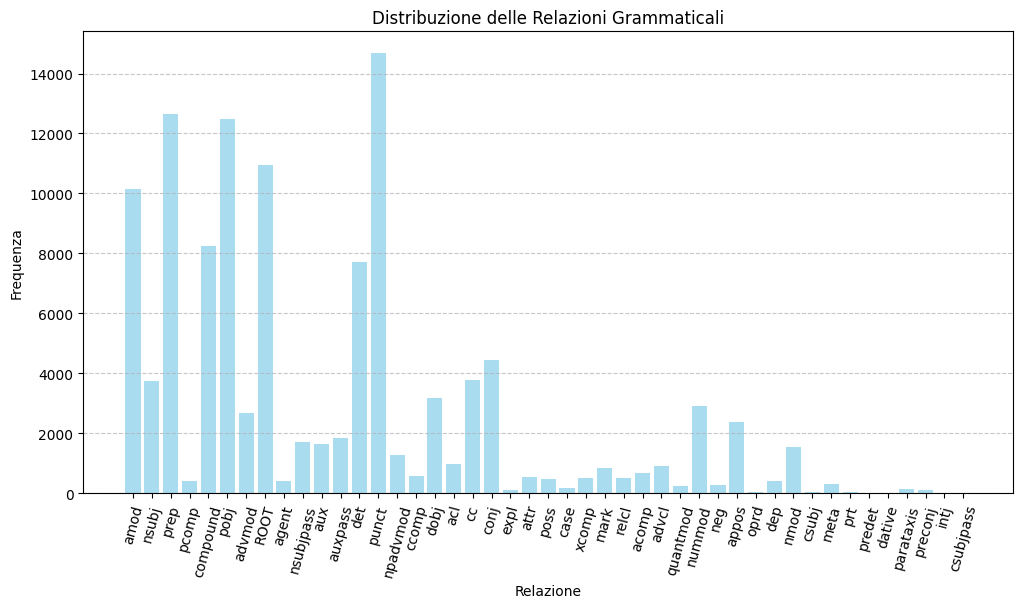

In [ ]:
# Funzione per estrarre relazioni di dipendenza
def extract_dependencies(text):
    doc = nlp(text)
    return [(token.text, token.dep_, token.head.text) for token in doc]

# Applica l'analisi delle dipendenze a ciascuna frase
unique_sentences['Dependencies'] = unique_sentences['sentence'].apply(extract_dependencies)

# Visualizza un esempio
print(unique_sentences['Dependencies'].head())

# Conta la frequenza delle relazioni grammaticali
dependency_counts = Counter([dep[1] for dep_list in unique_sentences['Dependencies'] for dep in dep_list])

# Grafico delle dipendenze più frequenti
plt.figure(figsize=(12, 6))
plt.bar(dependency_counts.keys(), dependency_counts.values(), color='skyblue', alpha=0.7)
plt.title("Distribuzione delle Relazioni Grammaticali")
plt.xlabel("Relazione")
plt.ylabel("Frequenza")
plt.xticks(rotation=75)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

From the graph this time we can see that the main functions of our tokens are ROOT (main verbs in a sentence), punct (punctuation, as expected from the previous analysis), compunds, prep (prepositions), amod (adjectival modifiers) and pobj (objects of prepositions)

# MOST FREQUENT TOKENS

Using the RegexpTokenizer(r'\w+') from NLTK, which employs the regular expression \w+ to extract alphanumeric sequences, we removed delimiters such as punctuation and other undesired symbols. This step was taken to focus the subsequent analysis on identifying semantic patterns and examining token frequency by class.

Following this, we leveraged spaCy to remove default stop words provided by the library. Since stop words often dominate token frequency counts, their removal aligns with the rationale behind eliminating delimiters: to ensure that the analysis emphasizes meaningful and semantically relevant tokens.

In [ ]:
#delimiters
tokenizer = RegexpTokenizer(r'\w+')
ds['id'] = ds['id'].apply(lambda x: ' '.join(tokenizer.tokenize(str(x))))

In [ ]:
#stopwords
nlp = spacy.load("en_core_web_sm")
print(nlp.Defaults.stop_words)

{'whom', 'show', 'of', 'their', 'former', 'various', 'its', 'alone', 'whatever', 'forty', 'your', 'much', 'but', 'somewhere', 'yet', 'might', 'others', 'she', 'whereafter', 'regarding', 'who', 'out', 'than', 'was', 'myself', 'does', 'throughout', '’d', 'up', 'been', 'twenty', 'itself', 'while', '‘ll', 'three', 'would', 'down', 'can', 'four', 'whereupon', 'whose', 'these', 'hereby', 'move', 'herself', 'by', 'herein', 'whole', 'nowhere', 'with', 'although', 'then', 'behind', 'already', 'yourselves', 'during', 'each', 'take', 'another', 'from', 'moreover', 'us', 'side', 'is', 'this', 'go', "n't", 'for', 'namely', 'fifteen', 'eleven', 'a', 'full', 'keep', 'beforehand', 'beyond', '‘re', 'five', 're', 'enough', "'re", 'to', 'over', 'say', 'therein', 'besides', 'whenever', 'before', 'also', 'eight', 'top', 'amongst', 'because', 'really', 'name', 'on', 'within', 'get', 'across', 'two', 'indeed', 'our', 'being', 'unless', 'you', 'except', 'where', 'above', 'noone', 'now', 'few', 'any', 'they', 

In [ ]:

# Carica il modello di Spacy
nlp = spacy.load("en_core_web_sm")

# Funzione per rimuovere le stop words
def remove_stop_words(text):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if not token.is_stop])

ds_withouth_stopwords =ds.copy()
# Applica la funzione e filtra le righe vuote
ds_withouth_stopwords['id'] = ds['id'].apply(remove_stop_words)

# Rimuovi le righe dove la colonna 'id' è vuota
ds_withouth_stopwords = ds_withouth_stopwords[ds_withouth_stopwords['id'].str.strip() != '']  # Filtra righe dove 'id' è vuota o solo spazi


In [ ]:
len(ds)


117618

In [ ]:
len(ds_withouth_stopwords)

61057

In [ ]:
ds_withouth_stopwords.head()

,id,Start,End,Label,Sentence_ID,sentence
0,Ventricular,0,11,B-Multi-tissue_structure,0,Ventricular fibrillation due to long QT syndro...
1,fibrillation,12,24,O,0,Ventricular fibrillation due to long QT syndro...
4,long,32,36,O,0,Ventricular fibrillation due to long QT syndro...
5,QT,37,39,O,0,Ventricular fibrillation due to long QT syndro...
6,syndrome,40,48,O,0,Ventricular fibrillation due to long QT syndro...


In [ ]:
most_common_tokens = ds_withouth_stopwords['id'].value_counts().head(10)
print(most_common_tokens)

id
1           551
0           499
5           404
2           400
patients    323
3           301
cells       236
4           236
6           195
study       180
Name: count, dtype: int64


Following, we represented the most frequent tokens for each label individually. This step helps to identify distinctive terms associated with specific labels, providing insights into the linguistic patterns that could be useful for model training and improving classification performance.

In [ ]:
# Conta i token più frequenti per ciascuna classe
most_common_tokens_per_class = (
    ds_withouth_stopwords.groupby('Label')['id']
    .value_counts()  # Conta i token per classe
    .groupby(level=0)  # Raggruppa di nuovo per classe
    .head(5)  # Prendi i primi 5 token per classe
)

# Trasforma in DataFrame con tutte le informazioni necessarie
most_common_tokens = most_common_tokens_per_class.reset_index(name='Frequency')

# Verifica che il risultato sia un DataFrame
print(type(most_common_tokens))  # Dovrebbe essere <class 'pandas.core.frame.DataFrame'>
print(most_common_tokens.head())  # Verifica la struttura


<class 'pandas.core.frame.DataFrame'>
                 Label             id  Frequency
0  B-Anatomical_system    respiratory          9
1  B-Anatomical_system  corticospinal          7
2  B-Anatomical_system   neurological          7
3  B-Anatomical_system        central          5
4  B-Anatomical_system       skeletal          5


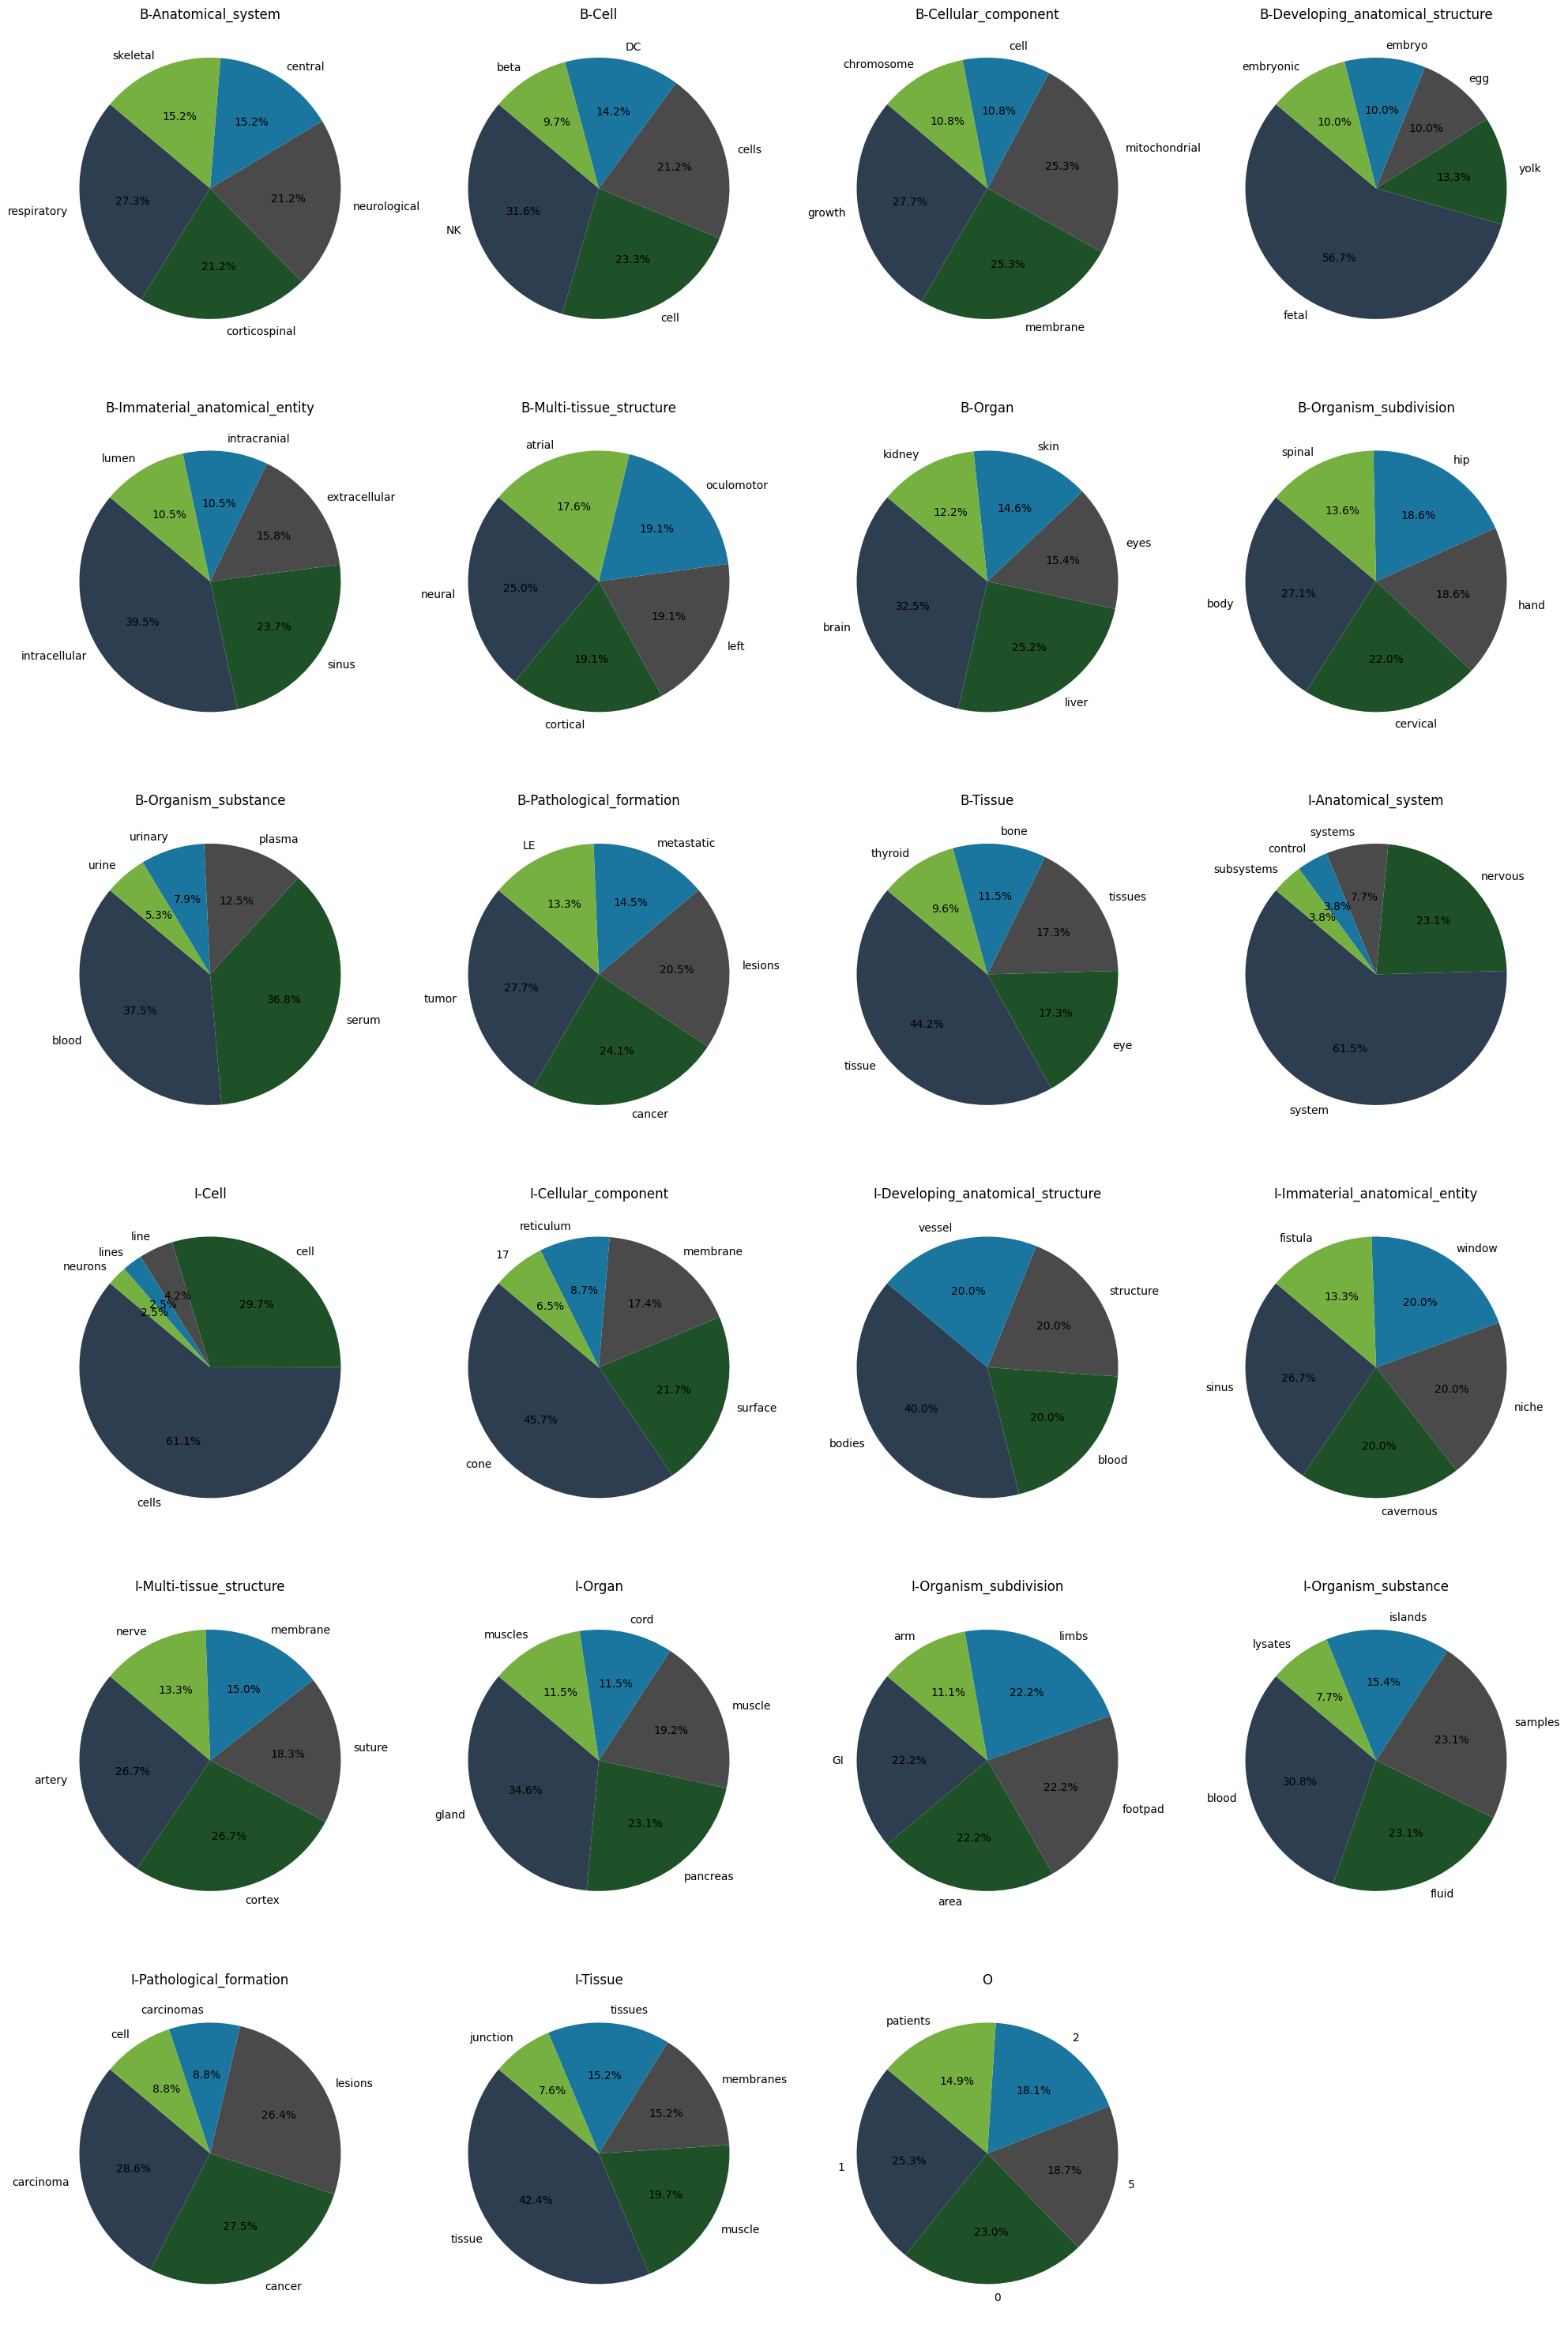

In [ ]:
import matplotlib.pyplot as plt

# Supponiamo che most_common_tokens sia un DataFrame già definito
num_classes = len(most_common_tokens['Label'].unique())  # 23 classi
num_cols = 4  # Numero di pie charts per riga
num_rows = -(-num_classes // num_cols)  # Calcola il numero di righe usando la divisione per soffitto

# Creiamo una figura e una griglia di sottotrame
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

# Flatten per semplificare l'indicizzazione
axs = axs.flatten()

# Cicliamo sulle classi per creare i grafici
for i, label in enumerate(most_common_tokens['Label'].unique()):
    class_tokens = most_common_tokens[most_common_tokens['Label'] == label]

    axs[i].pie(
        class_tokens['Frequency'],
        labels=class_tokens['id'],
        autopct='%1.1f%%',
        startangle=140,
        colors=['#2C3E50', '#1E5128', '#4A4A4A', '#1A759F', '#76B041',
                '#3C3C3C', '#1F4E5F', '#9DA5B0', '#2B9348', '#5C5C5C']
    )
    axs[i].set_title(label)

# Disabilitiamo gli assi inutilizzati
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

# Miglioriamo l'aspetto con tight_layout
plt.tight_layout()
plt.show()


In [ ]:
mapped_ds_withoutsw = ds_withouth_stopwords.copy()
ds2 = ds_withouth_stopwords.copy()
mapped_ds_withoutsw['Label'] = mapped_ds_withoutsw['Label'].map(mapping)
mapped_ds_withoutsw_O= mapped_ds_withoutsw[mapped_ds_withoutsw['Label'] != 'O']
ds_withoutsw_O = ds2[ds2['Label'] != 'O']
print(mapped_ds_withoutsw_O.head())

              id  Start  End                   Label  Sentence_ID  \
0    Ventricular      0   11  Multi-tissue_structure            0   
46   ventricular    294  305  Multi-tissue_structure            2   
302       faecal    377  383      Organism_substance           17   
330        meats    544  549    Organism_subdivision           19   
384    intestine    886  895                   Organ           21   

                                              sentence  
0    Ventricular fibrillation due to long QT syndro...  
46   . We describe a case of QT time interval prolo...  
302  . Enterococci can be used as indicators of fae...  
330  . In processed meats , enterococci may survive...  
384  . Enterococci are used as probiotics to improv...  


In [ ]:
# Conta i token più frequenti per ciascuna classe
most_common_tokens_per_class_map = (
    mapped_ds_withoutsw_O.groupby('Label')['id']
    .value_counts()  # Conta i token per classe
    .groupby(level=0)  # Raggruppa di nuovo per classe
    .head(5)  # Prendi i primi 5 token per classe
)

# Trasforma in DataFrame con tutte le informazioni necessarie
most_common_tokens_map = most_common_tokens_per_class_map.reset_index(name='Frequency')

# Verifica che il risultato sia un DataFrame
print(type(most_common_tokens_map))  # Dovrebbe essere <class 'pandas.core.frame.DataFrame'>
print(most_common_tokens_map.head())  # Verifica la struttura

<class 'pandas.core.frame.DataFrame'>
               Label             id  Frequency
0  Anatomical_system         system         16
1  Anatomical_system    respiratory          9
2  Anatomical_system  corticospinal          7
3  Anatomical_system        nervous          7
4  Anatomical_system   neurological          7


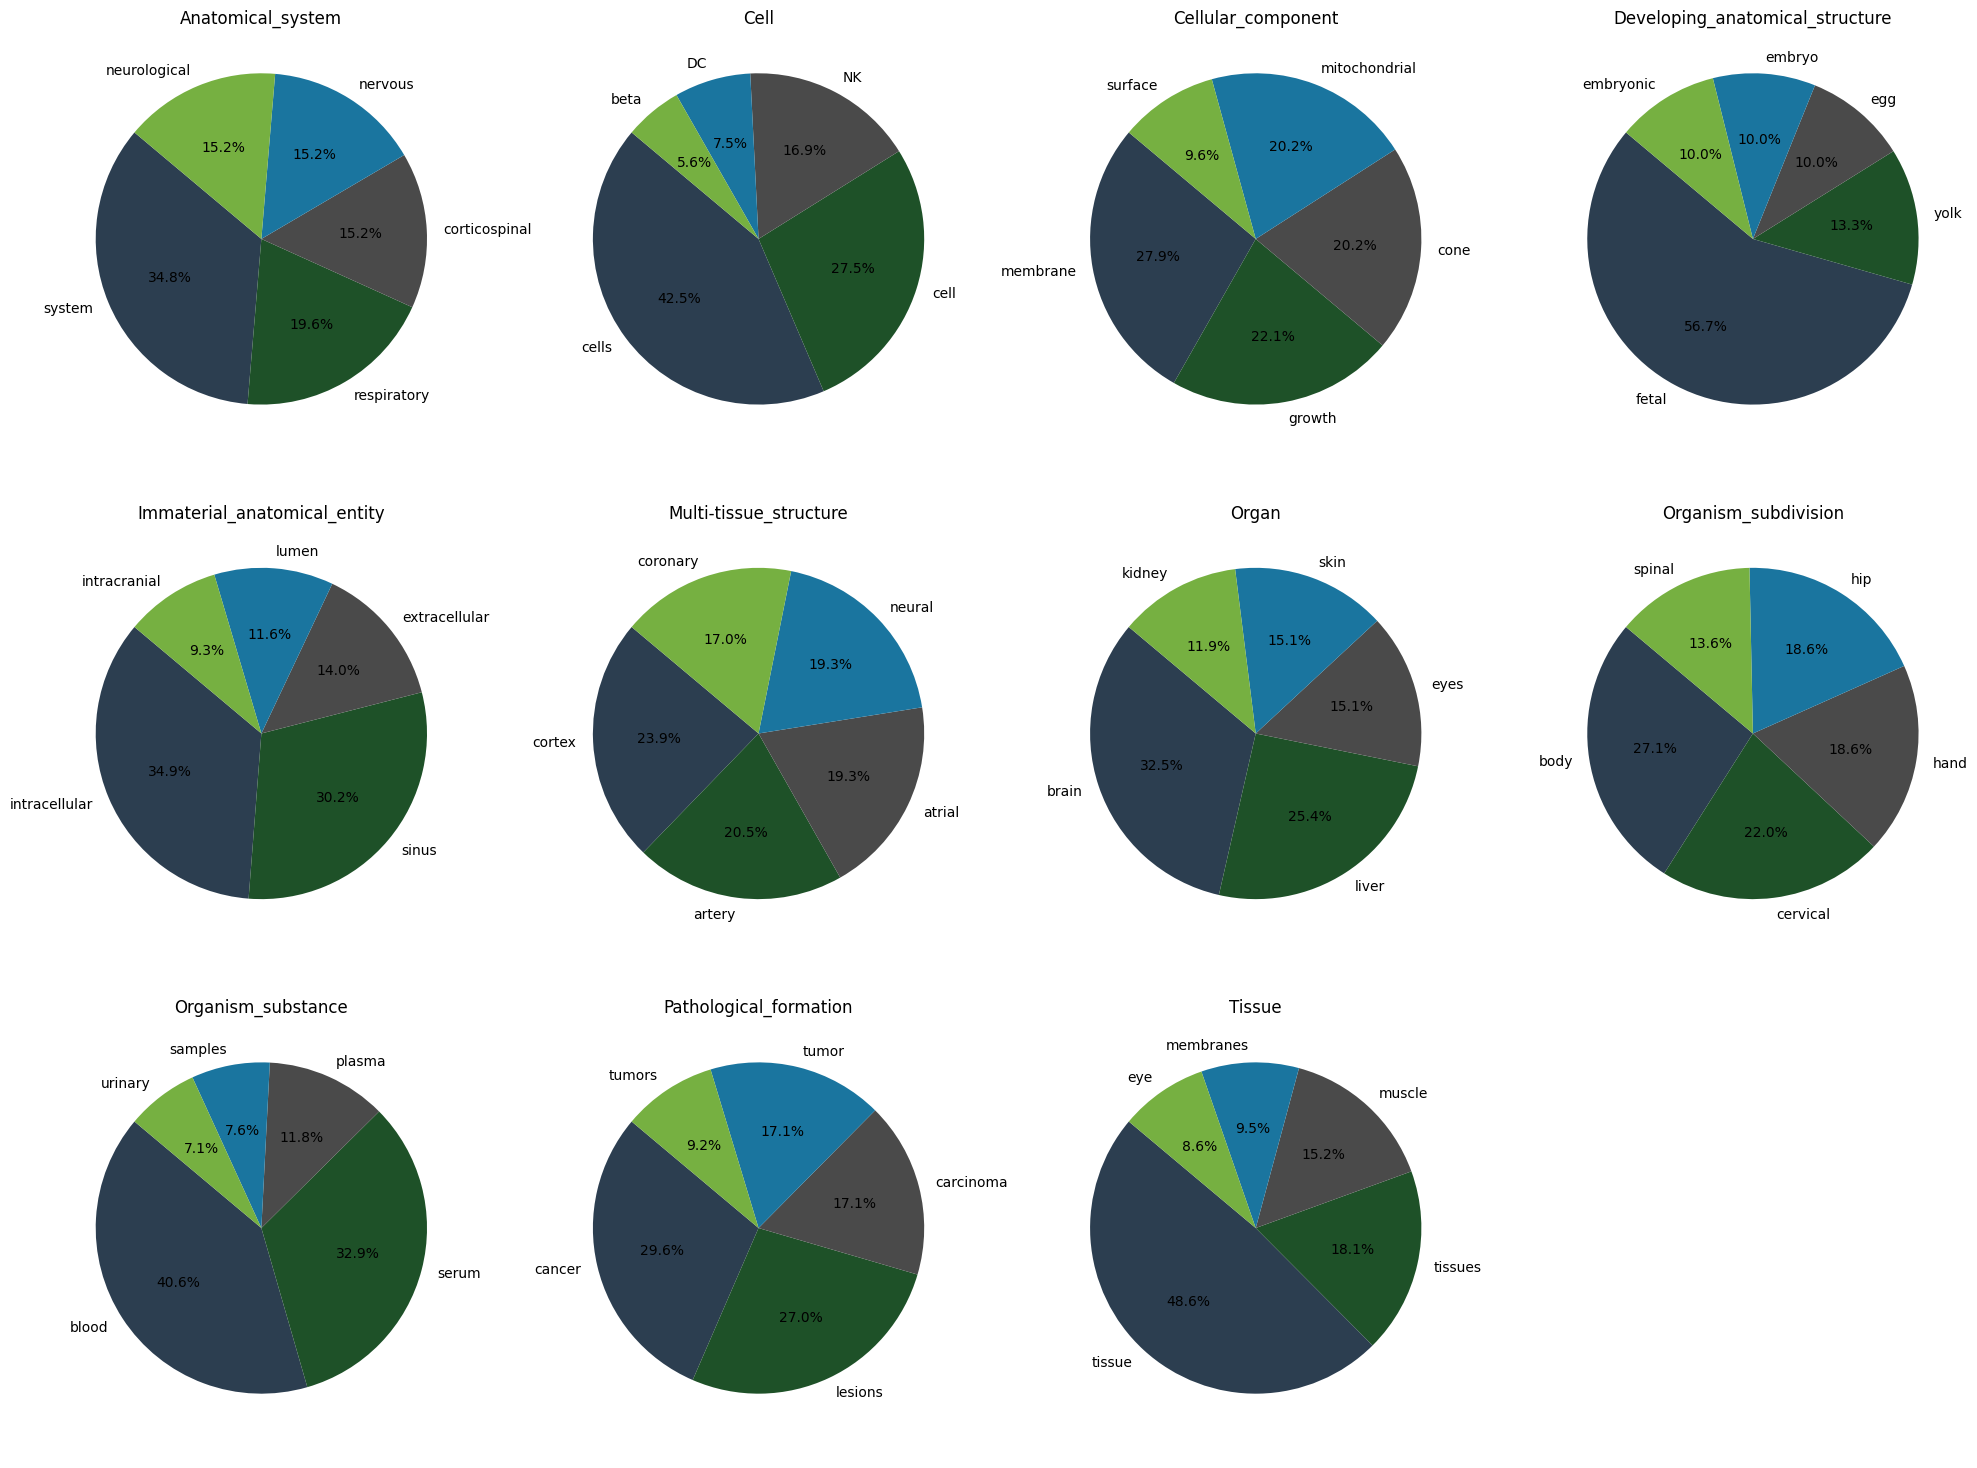

In [ ]:
num_charts = 11
num_cols = 4  # Number of pie charts per row
num_rows = -(-num_charts // num_cols)  # Calculate number of rows using ceiling division

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Plot the pie charts
for i, label in enumerate(most_common_tokens_map['Label'].unique()):
    class_tokens = most_common_tokens_map[most_common_tokens_map['Label'] == label]
    axs[i].pie(
        class_tokens['Frequency'],
        labels=class_tokens['id'],
        autopct='%1.1f%%',
        startangle=140,
        colors=['#2C3E50', '#1E5128', '#4A4A4A', '#1A759F', '#76B041',
                '#3C3C3C', '#1F4E5F', '#9DA5B0', '#2B9348', '#5C5C5C']
    )
    axs[i].set_title(label)

# Turn off any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


#DISTRIBUTION OF TOKEN LENGTHS

In [ ]:
ds_withouth_stopwords['token_length'] = ds_withouth_stopwords['id'].apply(len)
token_stats = ds_withouth_stopwords.groupby('Label')['token_length'].agg(['mean', 'median', 'std', 'min', 'max', ]).reset_index()
print(token_stats)

                                Label       mean  median       std  min  max
0                 B-Anatomical_system  10.000000    11.0  3.000000    3   15
1                              B-Cell   5.233548     4.0  3.177913    1   16
2                B-Cellular_component   8.713568     8.0  3.090122    1   15
3   B-Developing_anatomical_structure   5.615385     5.0  2.059834    3   14
4      B-Immaterial_anatomical_entity   9.450000    11.5  4.106320    4   17
5            B-Multi-tissue_structure   7.248826     7.0  2.591110    2   18
6                             B-Organ   5.776903     5.0  1.820957    2   12
7              B-Organism_subdivision   5.602484     5.0  2.559979    2   16
8                B-Organism_substance   5.850694     5.0  1.993526    2   14
9            B-Pathological_formation   7.092643     6.0  3.391105    2   19
10                           B-Tissue   7.130178     7.0  2.669421    2   15
11                I-Anatomical_system   6.500000     6.0  0.860233    6   10

As we can see the longest token with the label 'O' has a length of 505, which is a thing we have to deal with now because it could affect in a negative way our statistic analysis and NLP models, so first of all we decided to select all the tokens with a length bigger than 45 (length of the longest english word: Pneumonoultramicroscopicsilicovolcanoconiosis).
Then we made some tests on this word to check if they were codes or hashes or they were MathType or LaTeX or just noisy irrelevant tokens.

In [ ]:
over_length=ds_withouth_stopwords[ds_withouth_stopwords['token_length']>45]
print(over_length)

                                                      id  Start    End Label  \
63266  feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...    545    630     O   
63278  vr0dc8meaabaqaciaacaGaaeqabaqabeGadaaakeaacuWG...    723    840     O   
63302  feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...    883    968     O   
63314  vr0dc8meaabaqaciaacaGaaeqabaqabeGadaaakeaacuWG...   1061   1178     O   
63698  feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...   2887   2972     O   
...                                                  ...    ...    ...   ...   
65861  f8aYzaalaGaei4oaSJaemOEaONaeiykaKIafmiuaaLbaGa...  18939  19022     O   
65863  f8aYzaalaGaei4oaSJaemOEaONaeiykaKIaeiOla4IaaCz...  19023  19114     O   
65935  feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...  19263  19348     O   
65947  vr0dc8meaabaqaciaacaGaaeqabaqabeGadaaakeaacuWG...  19441  19943     O   
65953  f8aYnaaBaaaleaacqWGnbqtcqWGbbqqcqWGybawaeqaaOG...  19960  20071     O   

       Sentence_ID                     

In [ ]:
# Funzione per identificare potenziali hash (MD5, SHA1, SHA256, UUID)
def is_hash(token):
    # MD5: 32 alfanumerici
    # SHA1: 40 alfanumerici
    # SHA256: 64 alfanumerici
    hash_pattern = re.compile(r'^[a-fA-F0-9]{32}$|^[a-fA-F0-9]{40}$|^[a-fA-F0-9]{64}$|^[0-9a-fA-F-]{36}$')
    return bool(hash_pattern.match(token))

# Aggiungi una colonna per verificare se è un hash
over_length['is_hash'] = over_length['id'].apply(is_hash)

# Mostra i token che sono identificati come hash
print(over_length[over_length['is_hash'] == True]['id'])
# Funzione per controllare se un token contiene simboli o caratteri strani
def has_special_characters(token):
    return bool(re.search(r'[^a-zA-Z0-9]', token))

# Aggiungi una colonna per identificare i token con caratteri speciali
over_length['has_special_chars'] = over_length['id'].apply(has_special_characters)

# Mostra i token con caratteri speciali
print(over_length[over_length['has_special_chars'] == True]['id'])
# Funzione per identificare LaTeX o MathType
def is_latex_math(token):
    latex_pattern = re.compile(r'\\[a-zA-Z]+|\{.*\}|\^|\_')
    return bool(latex_pattern.search(token))

# Aggiungi una colonna per identificare i token LaTeX/MathType
over_length['is_latex_math'] = over_length['id'].apply(is_latex_math)

# Mostra i token che sono identificati come LaTeX o MathType
print(over_length[over_length['is_latex_math'] == True]['id'])
# Funzione per identificare sequenze alfanumeriche casuali (rumore)
def is_random_sequence(token):
    # Se il token ha solo numeri e lettere, ma è troppo lungo per essere una parola comune
    return bool(re.match(r'^[a-zA-Z0-9]{45,}$', token))

# Aggiungi una colonna per identificare le sequenze casuali
over_length['is_random'] = over_length['id'].apply(is_random_sequence)

# Mostra i token che sembrano sequenze casuali
print(over_length[over_length['is_random'] == True]['id'])


Series([], Name: id, dtype: object)
Series([], Name: id, dtype: object)
Series([], Name: id, dtype: object)
63266    feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...
63278    vr0dc8meaabaqaciaacaGaaeqabaqabeGadaaakeaacuWG...
63302    feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...
63314    vr0dc8meaabaqaciaacaGaaeqabaqabeGadaaakeaacuWG...
63698    feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...
                               ...                        
65861    f8aYzaalaGaei4oaSJaemOEaONaeiykaKIafmiuaaLbaGa...
65863    f8aYzaalaGaei4oaSJaemOEaONaeiykaKIaeiOla4IaaCz...
65935    feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...
65947    vr0dc8meaabaqaciaacaGaaeqabaqabeGadaaakeaacuWG...
65953    f8aYnaaBaaaleaacqWGnbqtcqWGbbqqcqWGybawaeqaaOG...
Name: id, Length: 78, dtype: object


In [ ]:
print(over_length.head(78))

                                                      id  Start    End Label  \
63266  feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...    545    630     O   
63278  vr0dc8meaabaqaciaacaGaaeqabaqabeGadaaakeaacuWG...    723    840     O   
63302  feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...    883    968     O   
63314  vr0dc8meaabaqaciaacaGaaeqabaqabeGadaaakeaacuWG...   1061   1178     O   
63698  feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...   2887   2972     O   
...                                                  ...    ...    ...   ...   
65861  f8aYzaalaGaei4oaSJaemOEaONaeiykaKIafmiuaaLbaGa...  18939  19022     O   
65863  f8aYzaalaGaei4oaSJaemOEaONaeiykaKIaeiOla4IaaCz...  19023  19114     O   
65935  feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...  19263  19348     O   
65947  vr0dc8meaabaqaciaacaGaaeqabaqabeGadaaakeaacuWG...  19441  19943     O   
65953  f8aYnaaBaaaleaacqWGnbqtcqWGbbqqcqWGybawaeqaaOG...  19960  20071     O   

       Sentence_ID                     

As we can see our analysis shows that all this tokens are supposed to be random "words" so we decided to remove them from our dataset.

In [ ]:
# Exclude rows where tokens are identified as random
ds_cleaned = ds_withouth_stopwords[~ds_withouth_stopwords['id'].isin(over_length[over_length['is_random'] == True]['id'])]

# Reset index for the cleaned dataset
ds_cleaned.reset_index(drop=True, inplace=True)
columns_to_remove = ['sentence', 'Sentence_ID','token_length']
ds_cleaned_NN = ds_cleaned.drop(columns=columns_to_remove, axis=1)


In [ ]:
ds_cleaned_NN.to_csv('cleaned_dataset_NN.csv', index=False)
print("Cleaned dataset saved as 'cleaned_dataset_NN.csv'")

Cleaned dataset saved as 'cleaned_dataset_NN.csv'


In [ ]:
# Check the size of the cleaned dataset
print(f"Original dataset size: {len(ds)}")
print(f"Cleaned dataset size: {len(ds_cleaned)}")

# Sample rows from the cleaned dataset
print(ds_cleaned.sample(10))

# Check if any over-length tokens remain
print(ds_cleaned[ds_cleaned['token_length'] > 45])

ds_cleaned.to_csv('cleaned_dataset.csv', index=False)
print("Cleaned dataset saved as 'cleaned_dataset.csv'")

Original dataset size: 117618
Cleaned dataset size: 60979
                  id  Start   End Label  Sentence_ID  \
33068        doublet   2400  2407     O         2951   
30529     ultimately   1392  1402     O         2755   
38054  traditionally    405   418     O         3468   
13646      Mortality    996  1005     O         1275   
57958        respond   7446  7453     O         5232   
24025        members    108   115     O         2187   
2349             100    454   457     O          209   
15100       specific   1283  1291     O         1406   
14236     alcoholics     68    78     O         1338   
29929     biological   1624  1634     O         2698   

                                                sentence  token_length  
33068  . Lens L1 ( achromat doublet 16 cm focal lengt...             7  
30529  . Loss of parkin function does not tip the bal...            10  
38054  . The clinical relevance of membrane - related...            13  
13646  . Cohorts of all gainfully

In [ ]:
ds_cleaned['token_length'] = ds_cleaned['id'].apply(len)
token_stats = ds_cleaned.groupby('Label')['token_length'].agg(['mean', 'median', 'std', 'min', 'max', ]).reset_index()
print(token_stats)

                                Label       mean  median       std  min  max
0                 B-Anatomical_system  10.000000    11.0  3.000000    3   15
1                              B-Cell   5.233548     4.0  3.177913    1   16
2                B-Cellular_component   8.713568     8.0  3.090122    1   15
3   B-Developing_anatomical_structure   5.615385     5.0  2.059834    3   14
4      B-Immaterial_anatomical_entity   9.450000    11.5  4.106320    4   17
5            B-Multi-tissue_structure   7.248826     7.0  2.591110    2   18
6                             B-Organ   5.776903     5.0  1.820957    2   12
7              B-Organism_subdivision   5.602484     5.0  2.559979    2   16
8                B-Organism_substance   5.850694     5.0  1.993526    2   14
9            B-Pathological_formation   7.092643     6.0  3.391105    2   19
10                           B-Tissue   7.130178     7.0  2.669421    2   15
11                I-Anatomical_system   6.500000     6.0  0.860233    6   10

Now we want to analyze the cumulative distribution of token lengths for each NER (Named Entity Recognition) category. It helps to understand how the different token lengths are associated with various recognized entity types in our dataset.

<Figure size 1200x800 with 0 Axes>

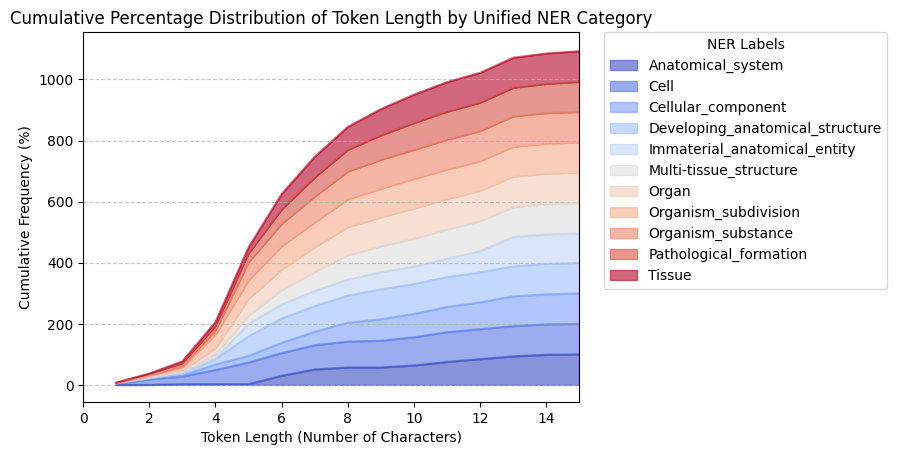

In [ ]:
# Create a new column with unified labels (removing IOB prefixes)
ds_cleaned['Unified_Label'] = ds_cleaned['Label'].str.replace(r'^[BI]-', '', regex=True)

# Filter out tokens with the "O" label (not named entities)
ds_filtered = ds_cleaned[ds_cleaned['Unified_Label'] != 'O']

# Calculate the token length distribution for each unified NER label
token_length_distribution = ds_filtered.groupby(['token_length', 'Unified_Label']).size().unstack(fill_value=0)

# Calculate the cumulative distribution for each category in percentage
token_length_distribution_cumsum = token_length_distribution.cumsum()
token_length_distribution_percent = (token_length_distribution_cumsum / token_length_distribution_cumsum.max()) * 100

# Create an area plot to represent the cumulative distribution
plt.figure(figsize=(12, 8))
token_length_distribution_percent.plot(kind='area', stacked=True, alpha=0.6, colormap="coolwarm")

plt.title("Cumulative Percentage Distribution of Token Length by Unified NER Category")
plt.xlabel("Token Length (Number of Characters)")
plt.ylabel("Cumulative Frequency (%)")
plt.legend(title="NER Labels", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(0, 15)  # Limit to 15 characters to focus on most token lengths

plt.show()


<Figure size 1200x800 with 0 Axes>

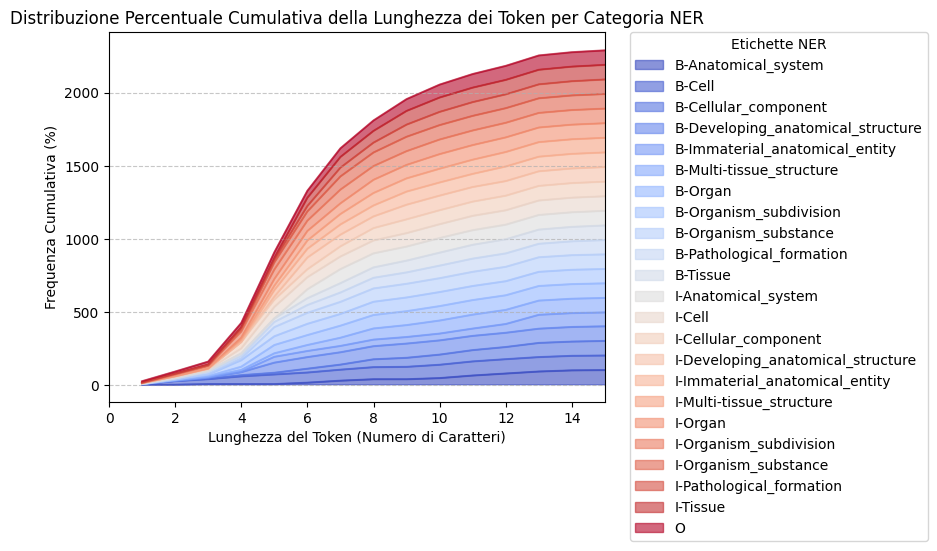

In [ ]:
# Calcolo della distribuzione delle lunghezze dei token per ciascuna categoria NER
token_length_distribution = ds_cleaned.groupby(['token_length', 'Label']).size().unstack(fill_value=0)

# Calcolo della distribuzione cumulativa per ogni categoria in percentuale
token_length_distribution_cumsum = token_length_distribution.cumsum()
token_length_distribution_percent = (token_length_distribution_cumsum / token_length_distribution_cumsum.max()) * 100

# Creazione del grafico ad area per rappresentare la distribuzione cumulativa
plt.figure(figsize=(12, 8))
token_length_distribution_percent.plot(kind='area', stacked=True, alpha=0.6, colormap="coolwarm")

plt.title("Distribuzione Percentuale Cumulativa della Lunghezza dei Token per Categoria NER")
plt.xlabel("Lunghezza del Token (Numero di Caratteri)")
plt.ylabel("Frequenza Cumulativa (%)")
plt.legend(title="Etichette NER",  bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.) #bbox per spostare la legenda a sinistra
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(0, 15)  # Limitiamo a 15 caratteri per visualizzare la maggior parte dei token

plt.show()

#WORD CLOUD

A word cloud is a graphical representation of the most frequent words in a dataset, where the size of each word is proportional to its frequency or importance. It's particularly useful in our Exploratory Data Analysis because by visualizing which words are used most frequently, we can gain insights into the content of our corpus, identify patterns, and form hypotheses for further investigation.

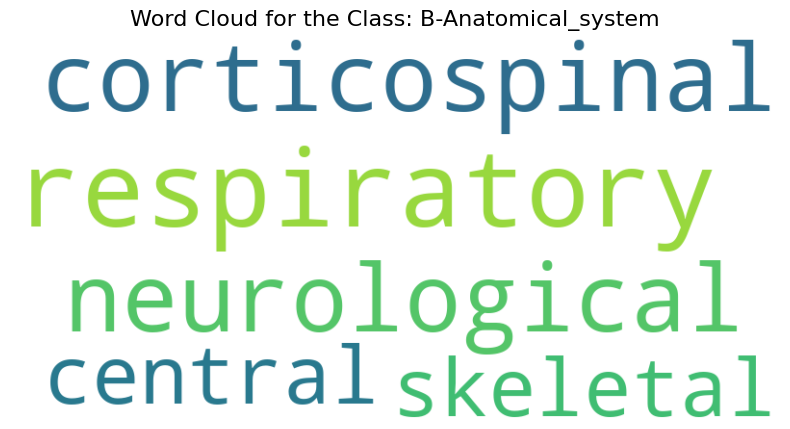

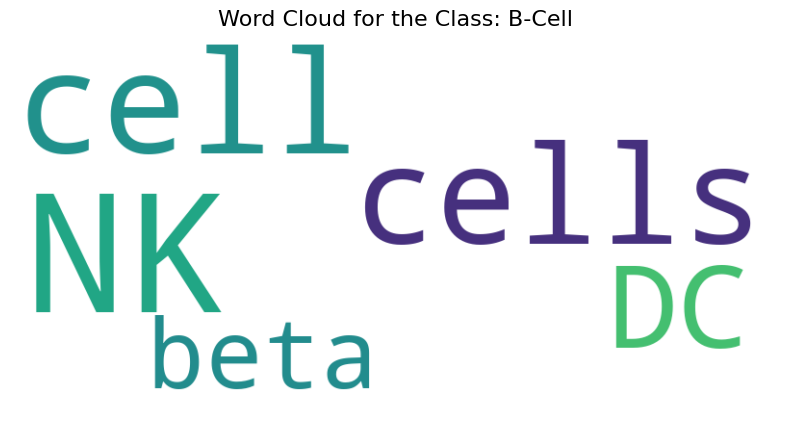

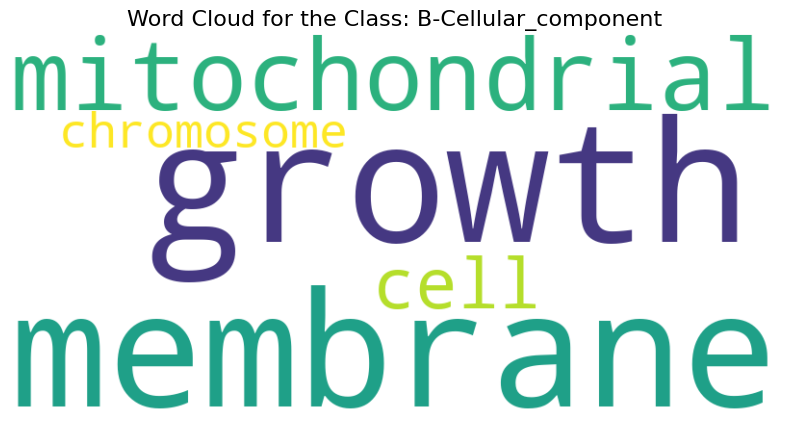

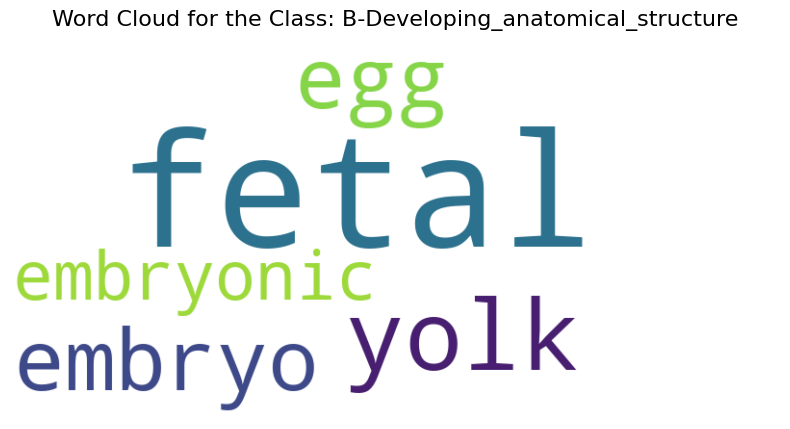

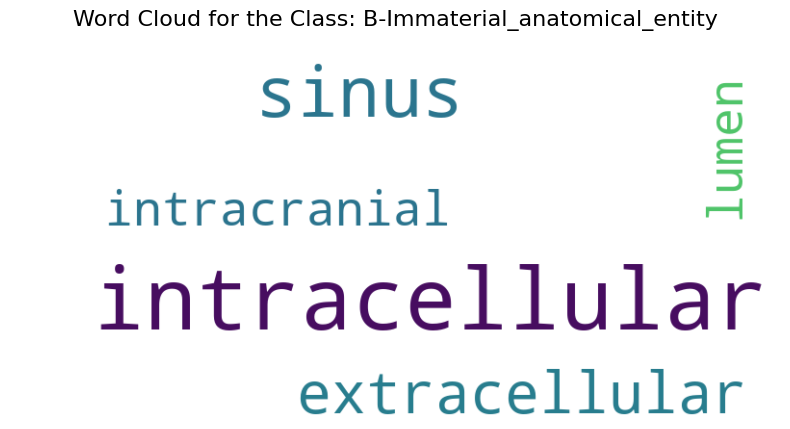

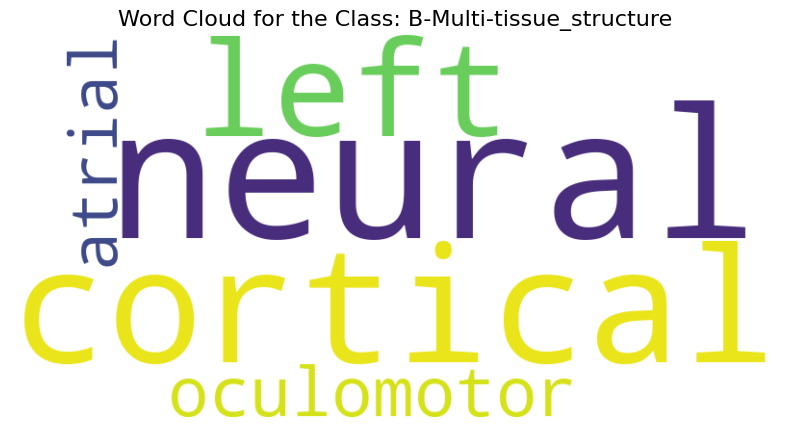

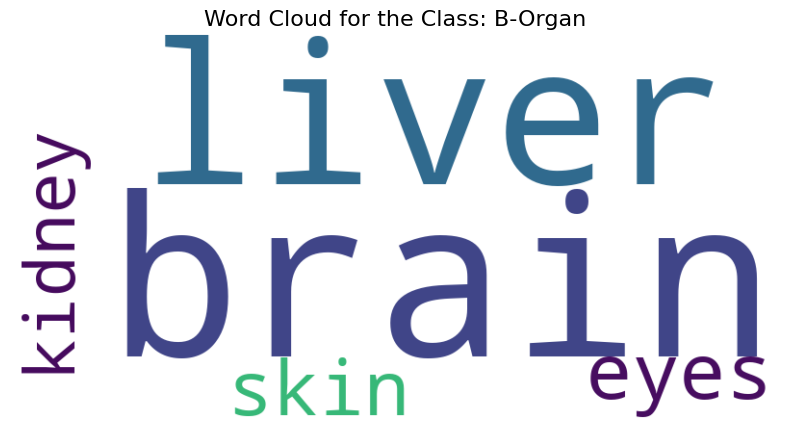

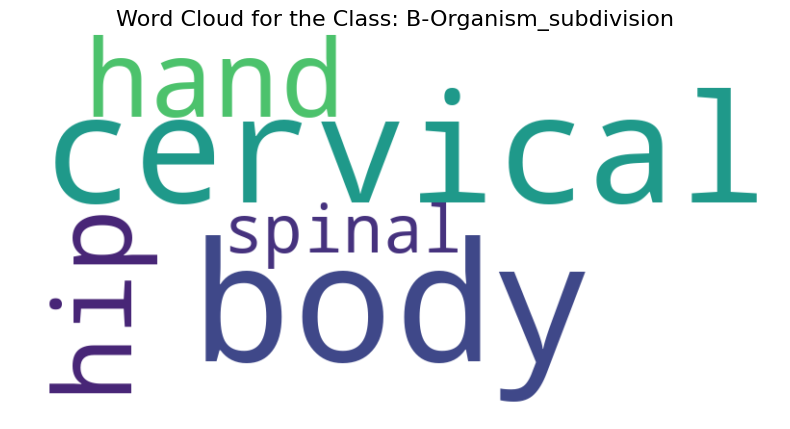

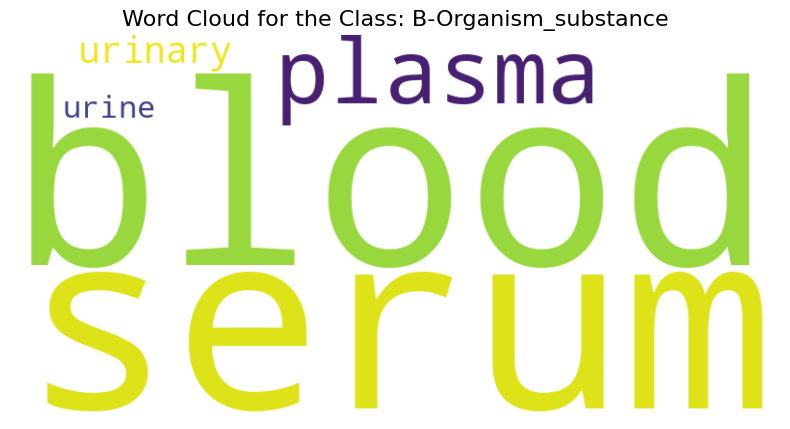

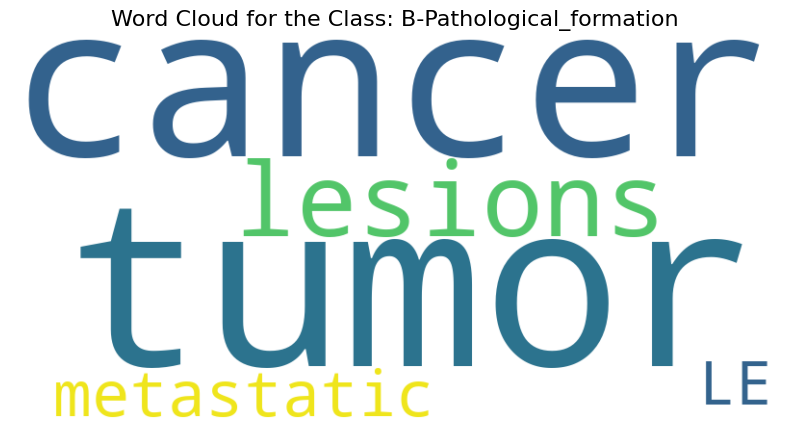

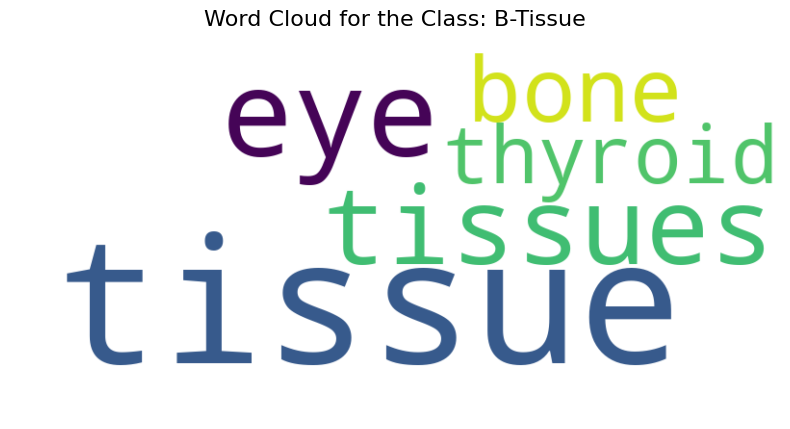

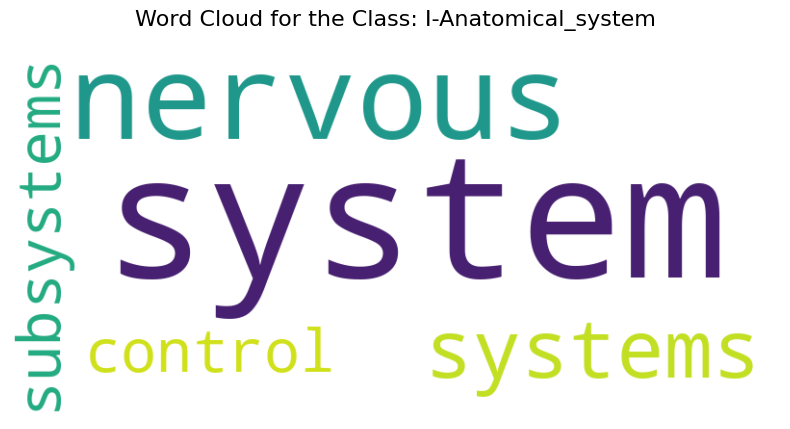

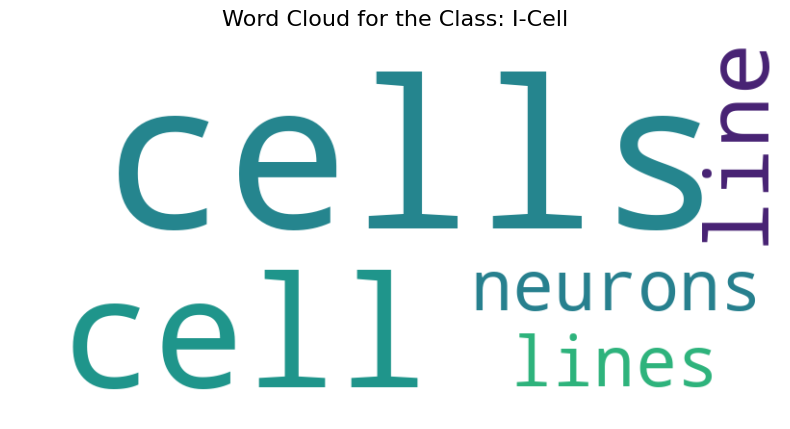

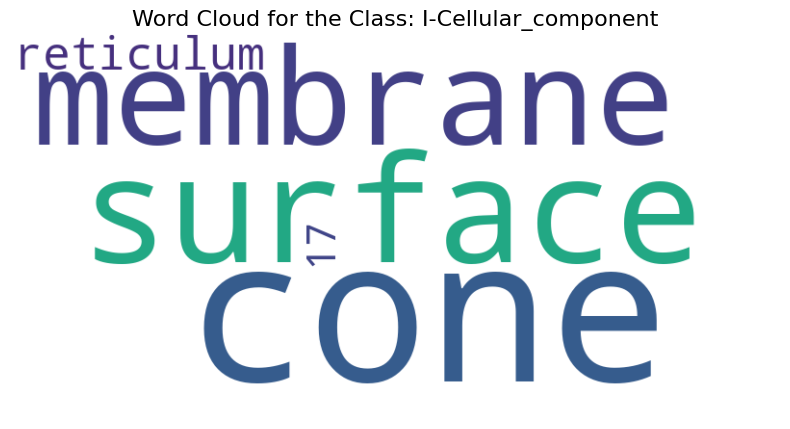

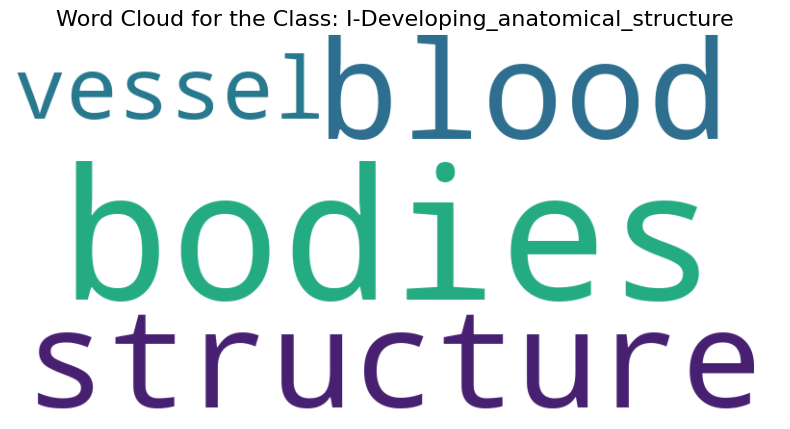

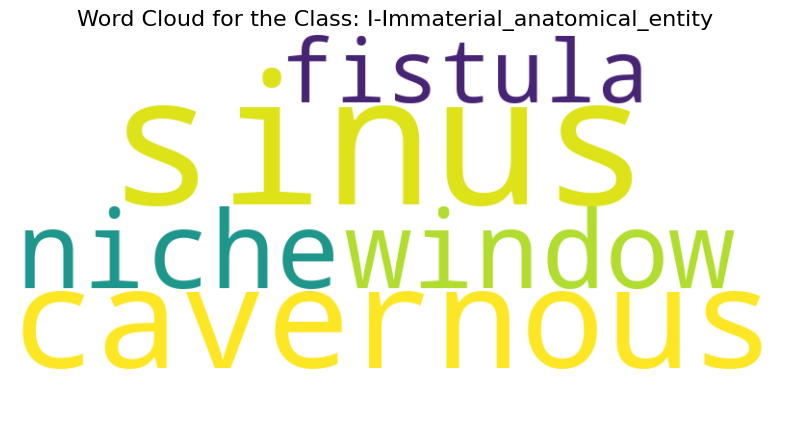

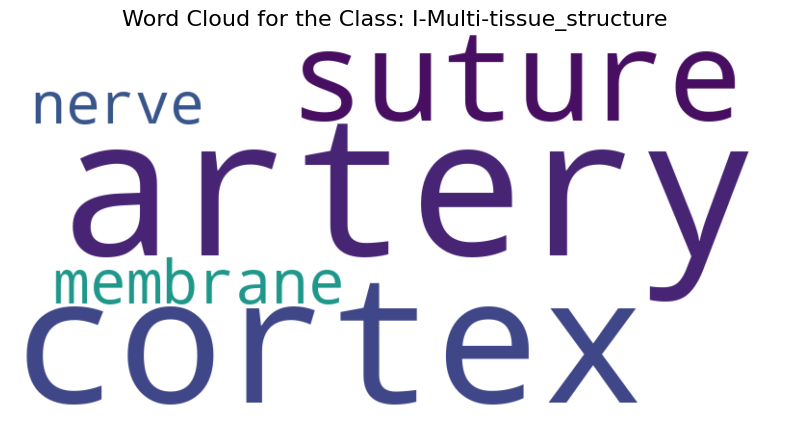

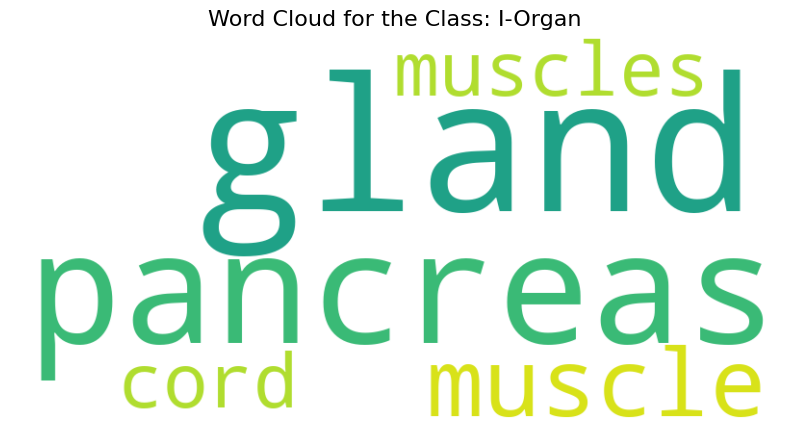

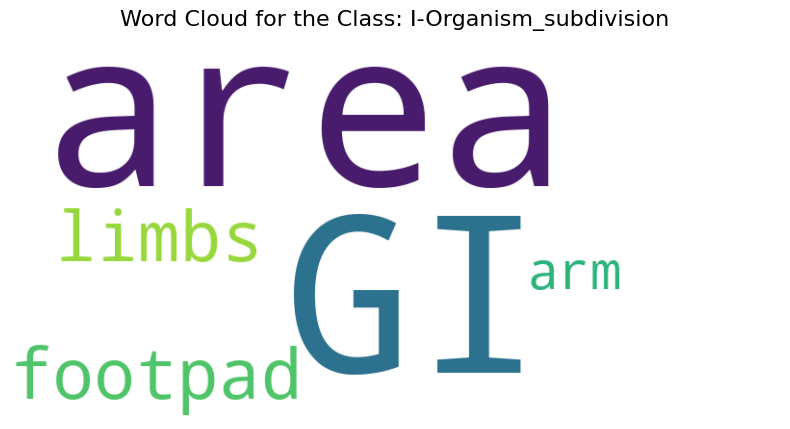

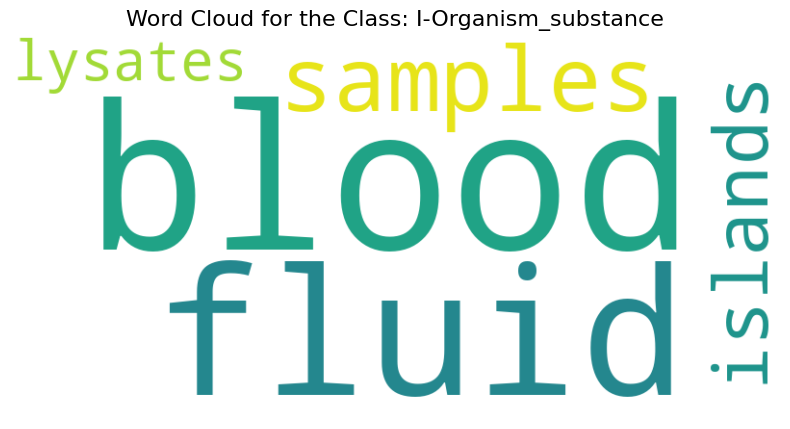

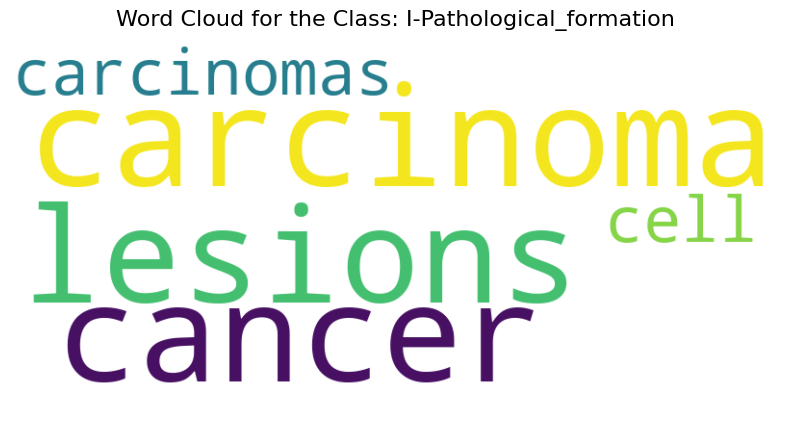

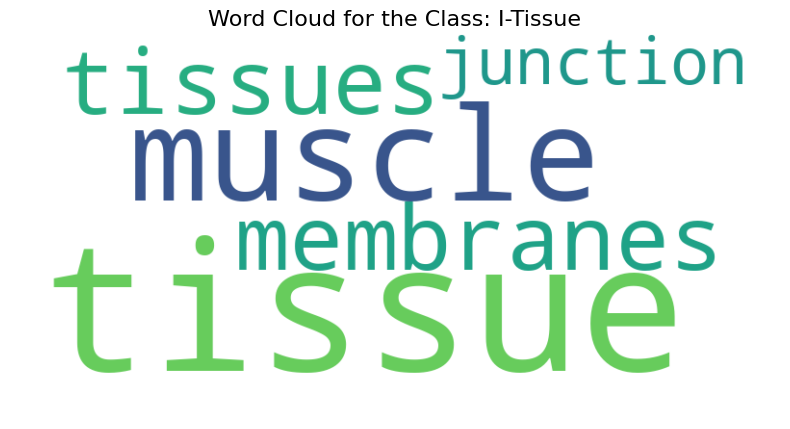

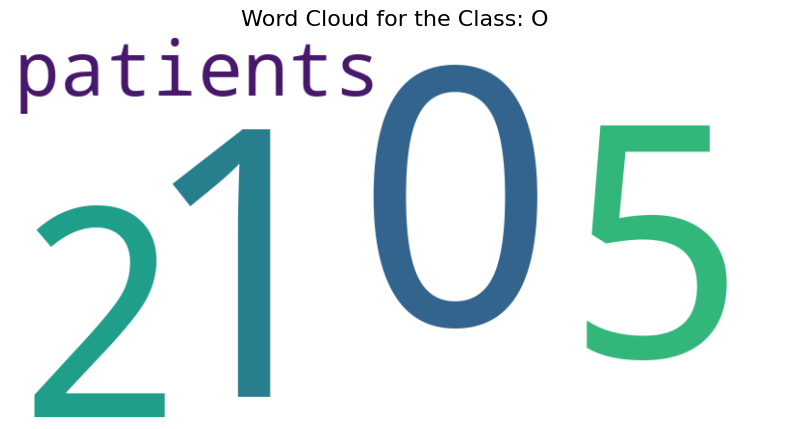

In [ ]:
# Funzione per creare la Word Cloud basata sulla frequenza dei token
def create_wordcloud_for_class(frequency_data, class_name):
    # Crea una stringa di testo con i token ripetuti in base alla loro frequenza
    word_freq = dict(frequency_data)

    # Crea la word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate_from_frequencies(word_freq)

    # Visualizza la Word Cloud
    plt.figure(figsize=(10, 5))
    plt.imshow( wordcloud, interpolation='bilinear')
    plt.axis('off')  # Disabilita l'asse
    plt.title(f"Word Cloud for the Class: {class_name}", fontsize=16)
    plt.show()


# Ora creiamo la Word Cloud per ciascuna classe
for class_name in most_common_tokens['Label'].unique():
    # Estrai i dati di frequenza per la classe
    class_data = most_common_tokens[most_common_tokens['Label'] == class_name]
    # Crea la Word Cloud per questa classe
    create_wordcloud_for_class(class_data[['id', 'Frequency']].values, class_name)


#LDA

Latent Dirichlet Allocation (LDA) is a popular topic modeling technique used for discovering hidden topics in large text datasets. LDA is particularly useful for analyzing and understanding large amounts of unstructured text. LDA assumes that each document is a mixture of a small number of topics, and each topic is a distribution over words. It identifies which topics are most prevalent in each document and which words are most representative of each topic.

In [ ]:
tokens = ds_cleaned['id'].apply(lambda x: [word.lower() for word in x.split() if word.isalpha() and word.lower() not in nlp.Defaults.stop_words])
# Create a dictionary from the cleaned tokens
dictionary = corpora.Dictionary(tokens)

# Create the corpus (Bag-of-Words format)
corpus = [dictionary.doc2bow(text) for text in tokens]

Now we look for the best number of topics in our dataset

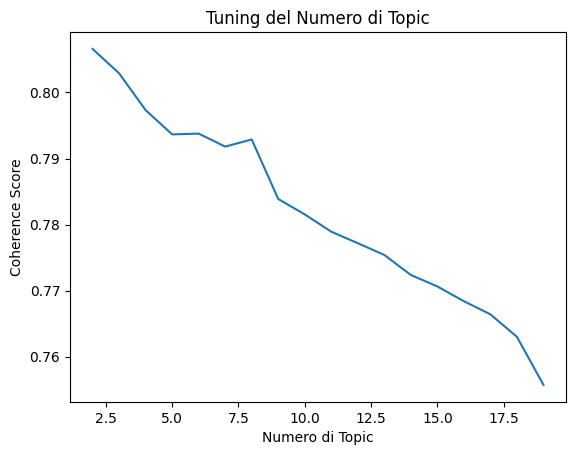

Best number of topics: 2


In [ ]:
# Prova vari numeri di topic
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list, coherence_values

# Specifica il range dei topic
start = 2
limit = 20
step = 1

# Esegui il tuning
model_list, coherence_values = compute_coherence_values(dictionary, corpus, tokens, start, limit, step)

# Visualizza i risultati
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Numero di Topic")
plt.ylabel("Coherence Score")
plt.title("Tuning del Numero di Topic")
plt.show()

# Mostra il miglior numero di topic
best_num_topics = x[np.argmax(coherence_values)]
print("Best number of topics:", best_num_topics)


A result of just two topics suggests that the documents in our dataset can be classified into two major categories or themes. This implies that the content we're analyzing is fairly homogeneous or that the topics are highly distinct.

In [ ]:
# Train the LDA model (set the number of topics to 5)
num_topics = best_num_topics
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=15)

# Print the topics discovered
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

# Visualize the topics using pyLDAvis
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)


(0, '0.007*"data" + 0.006*"cells" + 0.006*"expression" + 0.005*"study" + 0.005*"analysis" + 0.005*"results" + 0.004*"growth" + 0.004*"platelet" + 0.004*"model" + 0.004*"development"')
(1, '0.010*"cell" + 0.008*"patients" + 0.006*"beta" + 0.005*"fig" + 0.005*"s" + 0.004*"c" + 0.004*"number" + 0.004*"gene" + 0.004*"protein" + 0.004*"dna"')


# CONCLUSION

During the Data Exploratory Analysis (DEA), several key aspects were identified to prepare the dataset effectively for subsequent modeling steps.

Firstly we removed missing values in the dataset, since they could introduce biases or compromise the reliability of further analyses.

A critical focus of the analysis was on the classification labels used for Named Entity Recognition (NER). Initially, the labels were divided into two categories, prefixed with "B-" and "I-", indicating the beginning and continuation of an entity, respectively. To simplify interpretation and improve the dataset’s balance, these labels were consolidated into single representative categories. This approach reduced complexity while retaining the essential distinctions required for effective classification.

One particularly significant finding was the pronounced imbalance among the classes. The "Outside (O)" label, representing tokens outside recognized entities, accounted for 95% of the total. Hence, our model will potentially necessitating balancing strategies or weighting adjustments to avoid biased results.

Graphical representations of the labels through histograms underscored the differences before and after the label mapping. Before the mapping, the dataset exhibited greater granularity, with detailed distinctions between the labels. After the mapping, class balance improved, simplifying the classification task without compromising the critical information needed for entity extraction.

In summary, the exploratory analysis provided a comprehensive understanding of the dataset's characteristics and potential challenges, laying a solid foundation for effective and targeted modeling. This process optimized the dataset, setting the stage for more robust and reliable outcomes.